In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, e
import scipy.stats as stats
import random

In [2]:
#encodes the response into a vector with binary entrances
def encode(response, domain):
    return [1 if d == response else 0 for d in domain]

# The Data

In [3]:
df = pd.read_csv('lending_a.csv', sep=',')

C:\Users\renan.oliveira\AppData\Local\Temp\ipykernel_15144\28018411.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('lending_a.csv', sep=',')


In [4]:
pd.set_option('display.max_columns', None)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

## response getter(aggregates with no noise)

In [5]:
#gives you the responses, taht is , the frequency of each domain
#returns the responses
def get_responses(attribute):
    domain = df[attribute].dropna().unique()
    responsesREAL = df[attribute].dropna() 
    
    r = np.zeros(len(domain), dtype=int)
    
    for response in responsesREAL:
        r += encode(response, domain)
    
    return r

In [6]:
o = get_responses('home_ownership')
print(sum(o))

2260668


In [7]:
l = get_responses('loan_amnt')
print(l)
print(len(l))

[  9190    259 131006 ...      1      1      1]
1572


# Algorithms

## DP

In [8]:
def laplace_mech(answer, sensitivity, epsilon):
    return answer + np.random.laplace(loc=0, scale=sensitivity / epsilon)

## LDP

### OUE

In [9]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

In [10]:
def OUEresponses(responses, epsilon):
    p, q = optimized_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p, q, n)  

### UE

In [11]:
def unary_epsilon(p, q):
    return np.log(p*(1-q)/((1-p)*q))

In [12]:
def symetric_p_q(epsilon):
    p = (e**(epsilon/2)) / (e**(epsilon/2) + 1)
    q = 1 / (e**(epsilon/2) + 1)

    return p, q

In [13]:
def perturb_onto_agg(responses, p , q):
    noisy_responses = np.zeros(len(responses))
    #print("SOMA: ",sum(responses))
    
    for i in range(len(responses)):
        #print("i",i)
        for j in range(responses[i]):
            #print("j",j)
            for k in range(len(noisy_responses)):
                #print("k",k)
                #works hence the internal for iterates each one time for a singular unit
                sample = np.random.random()
                
                #case bit is 1(same cell, therefore using p)
                if i == k:
                    #print("here")
                    if sample <= p:
                        #tell the turht
                        #by adding 1 to the i(k) position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else:
                        #lie
                        #by not adding anything to the vector
                #handles other cells(using q probability)
                else:
                    #print("there")
                    if sample <= q:
                        #lie
                        #by summing 1 onto the k position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else: 
                        #truth
                        #by omiting form it
    return noisy_responses

In [14]:
def adjustUE(noisy_responses, p, q, n):
    d = len(noisy_responses)
    copyUE = noisy_responses.copy().astype(int)
    
    for i in range(len(copyUE)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copyUE[i] = a * copyUE[i] - b

    return copyUE

In [15]:
def UEresponses(responses, epsilon):
    p, q = symetric_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p ,q, n)

### DE

In [16]:
def DE_p_q(epsilon, d):
    p = (e**epsilon) / (e**epsilon + d - 1)

    q = (1 - p) / (d - 1)

    return p, q

In [17]:
#case de mehcanism decides the response to be fake, ramdomly picks all the values but the truthful response of the domain
def random_pick_DE(domain, response):
    domain_q = [i for i in domain if i != response]
    return random.choice(domain_q)

In [18]:
def randomized_responses_DE(responses, epsilon):
    d = len(responses)
    domain = [i for i in range(0, d)]
    p, q = DE_p_q(epsilon, d)

    noisy_responses = np.zeros(len(responses))

    for i in range(len(responses)):
        for j in range(responses[i]):
            sample = np.random.random()

            if sample <= p:
                #tell the truth
                #by adding to noisy_responses in the i position
                noisy_responses[i] = noisy_responses[i] + 1

            else:
                #lie
                #by adding to noisy_responses in any position but i 
                any_pos_but_i = random_pick_DE(domain, i)
                noisy_responses[any_pos_but_i] = noisy_responses[any_pos_but_i] + 1

    return noisy_responses

In [19]:
def adjustDE(noisy_responses, epsilon, n):
    d = len(noisy_responses)
    p, q = DE_p_q(epsilon, d)
    copy = noisy_responses.copy().astype(int)
    
    for i in range(len(copy)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copy[i] = a * copy[i] - b

    return copy

In [20]:
def DEresponses(responses, epsilon):
    n = sum(responses)
    return adjustDE(randomized_responses_DE(responses, epsilon), epsilon, n)

# Metrics

In [21]:
def metrics(exact, approx):
    if len(exact) != len(approx):
        raise ValueError("The length must be the same.")

    mse = np.mean([(exact[i] - approx[i])**2 for i in range(len(exact))])
    return mse

# Cooking

## bunch

In [25]:
# 5 times
def meid(times, attribute):
    domain = df[attribute].dropna().unique()
    responses = get_responses(attribute)
    d = len(domain)

    epsilon_sum = None
    mseOUE_sum = None
    mseUE_sum = None
    mseDE_sum = None
    mseLA_sum = None

    for i in range(times):
        epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE, mse_valuesLA = comparator2(attribute, responses, d)
        
        if epsilon_sum is None:
            epsilon_sum = np.zeros(len(epsilon_values))
            mseOUE_sum = np.zeros(len(mse_valuesOUE))
            mseUE_sum = np.zeros(len(mse_valuesUE))
            mseDE_sum = np.zeros(len(mse_valuesDE))
            mseLA_sum = np.zeros(len(mse_valuesLA))

        epsilon_sum = [x + y for x, y in zip(epsilon_sum, epsilon_values)]
        mseOUE_sum = [x + y for x, y in zip(mseOUE_sum, mse_valuesOUE)]
        mseUE_sum = [x + y for x, y in zip(mseUE_sum, mse_valuesUE)]
        mseDE_sum = [x + y for x, y in zip(mseDE_sum, mse_valuesDE)]
        mseLA_sum = [x + y for x, y in zip(mseLA_sum, mse_valuesLA)]


    epsilon_avg = [x / times for x in epsilon_sum]
    mseOUE_avg = [x / times for x in mseOUE_sum]
    mseUE_avg = [x / times for x in mseUE_sum]
    mseDE_avg = [x / times for x in mseDE_sum]
    mseLA_avg = [x / times for x in mseLA_sum]

    return epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg, mseLA_avg

In [26]:
def comparator2(attribute, responses, d):
    mse_valuesDE = []
    mse_valuesUE = []
    mse_valuesOUE = []
    mse_valuesLA = []

    epsilon_values = []
    
    for i in np.arange(0.1, 5.1, 0.5):
        epsilon = i
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pUE, qUE = symetric_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, d)
    
        ##--------------------------------------------------------------
        responsesUE =  UEresponses(responses, epsilon)
        responsesOUE = OUEresponses(responses, epsilon)
        responsesDE = DEresponses(responses, epsilon)

        responsesLA = laplace_mech(responses, 1, epsilon/d)
        ##--------------------------------------------------------------
    
        mseOUE = metrics(responses, responsesOUE)
        mseDE = metrics(responses, responsesDE)
        mseUE = metrics(responses, responsesUE)
        mseLA = metrics(responses, responsesLA)
    
        mse_valuesOUE.append(mseOUE)
        mse_valuesUE.append(mseUE)
        mse_valuesDE.append(mseDE)
        mse_valuesLA.append(mseLA)
        
        epsilon_values.append(epsilon)
        
    return  epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE, mse_valuesLA

## plot

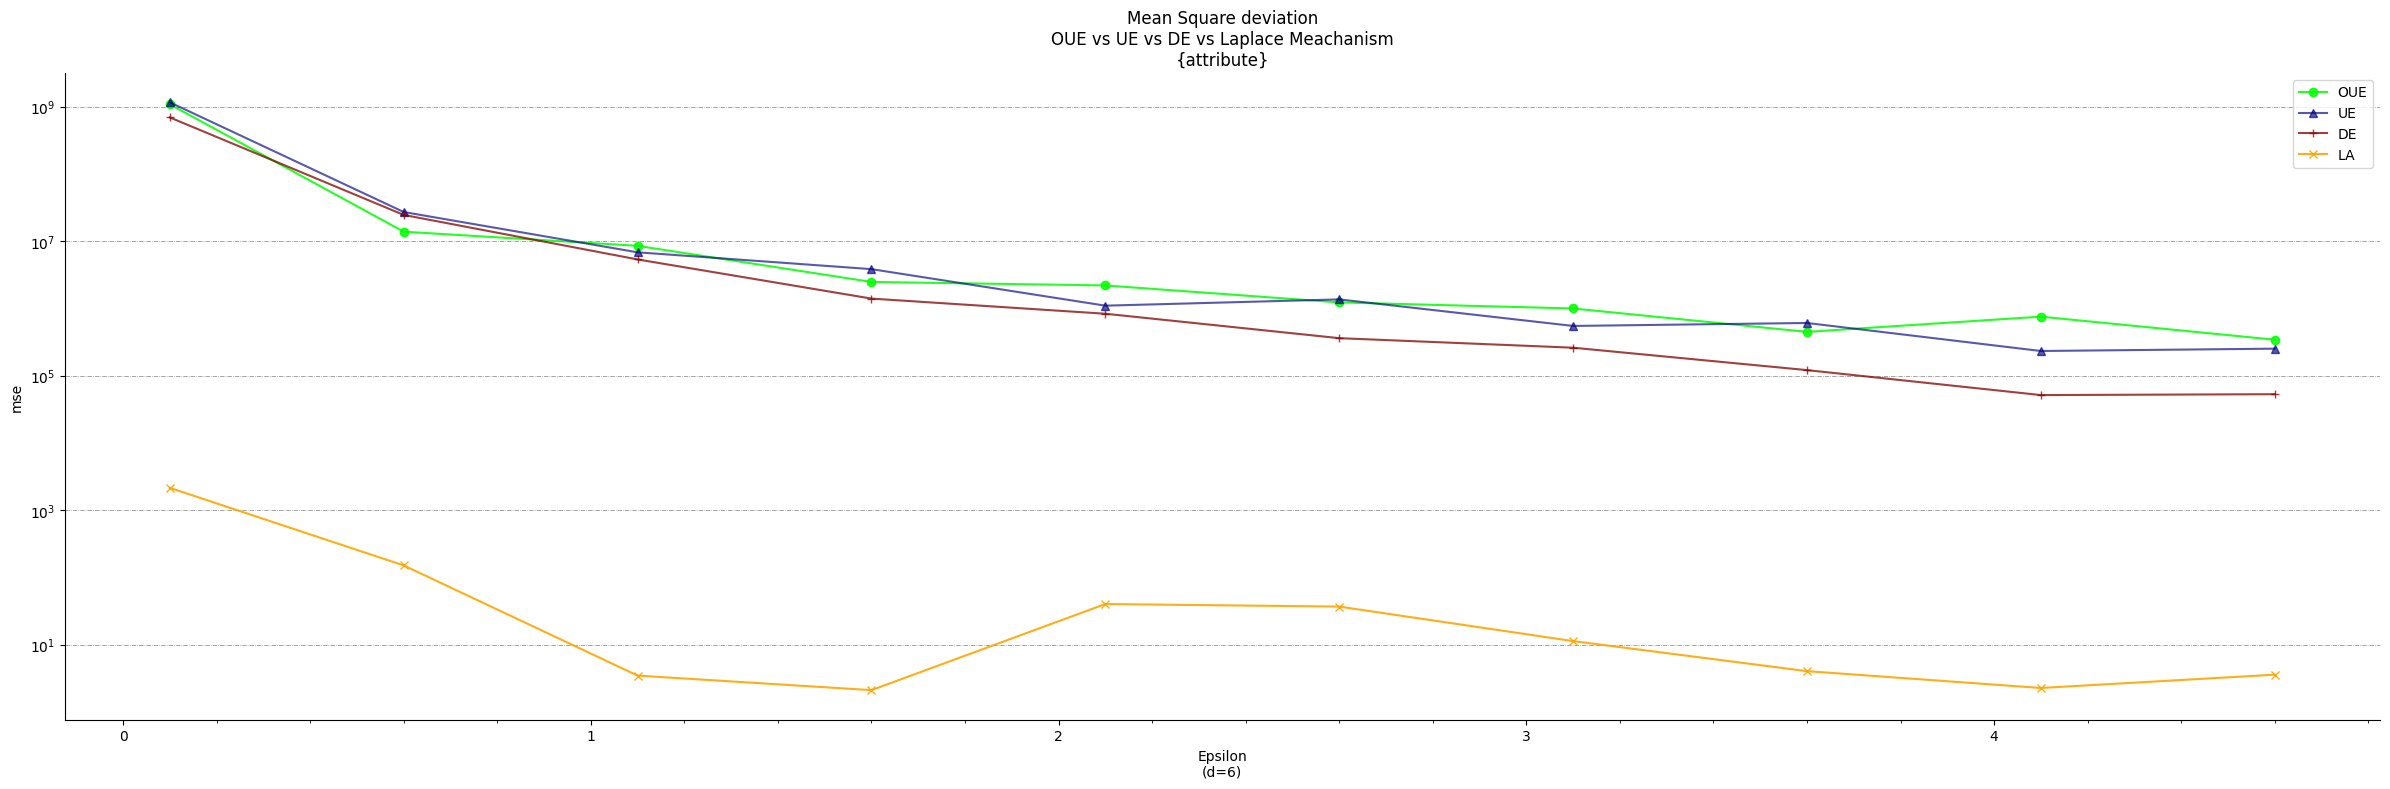

In [98]:
attribute = 'home_ownership'
epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg, mseLA_avg = meid(5, attribute)
d = len(df[attribute].dropna().unique())
plt.figure(figsize=(24, 8))

plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
plt.plot(epsilon_avg, mseUE_avg, marker='^', color='navy', alpha=0.65, label='UE')
plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
plt.plot(epsilon_avg, mseLA_avg, marker='x', color='orange', alpha=0.9, label='LA')

plt.title('Mean Square deviation\nOUE vs UE vs DE vs Laplace Meachanism\n{attribute}')
plt.xlabel(f'Epsilon\n(d={d})')
plt.ylabel('mse')
plt.yscale('log')
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.minorticks_on()

plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')

plt.tight_layout()
plt.show()

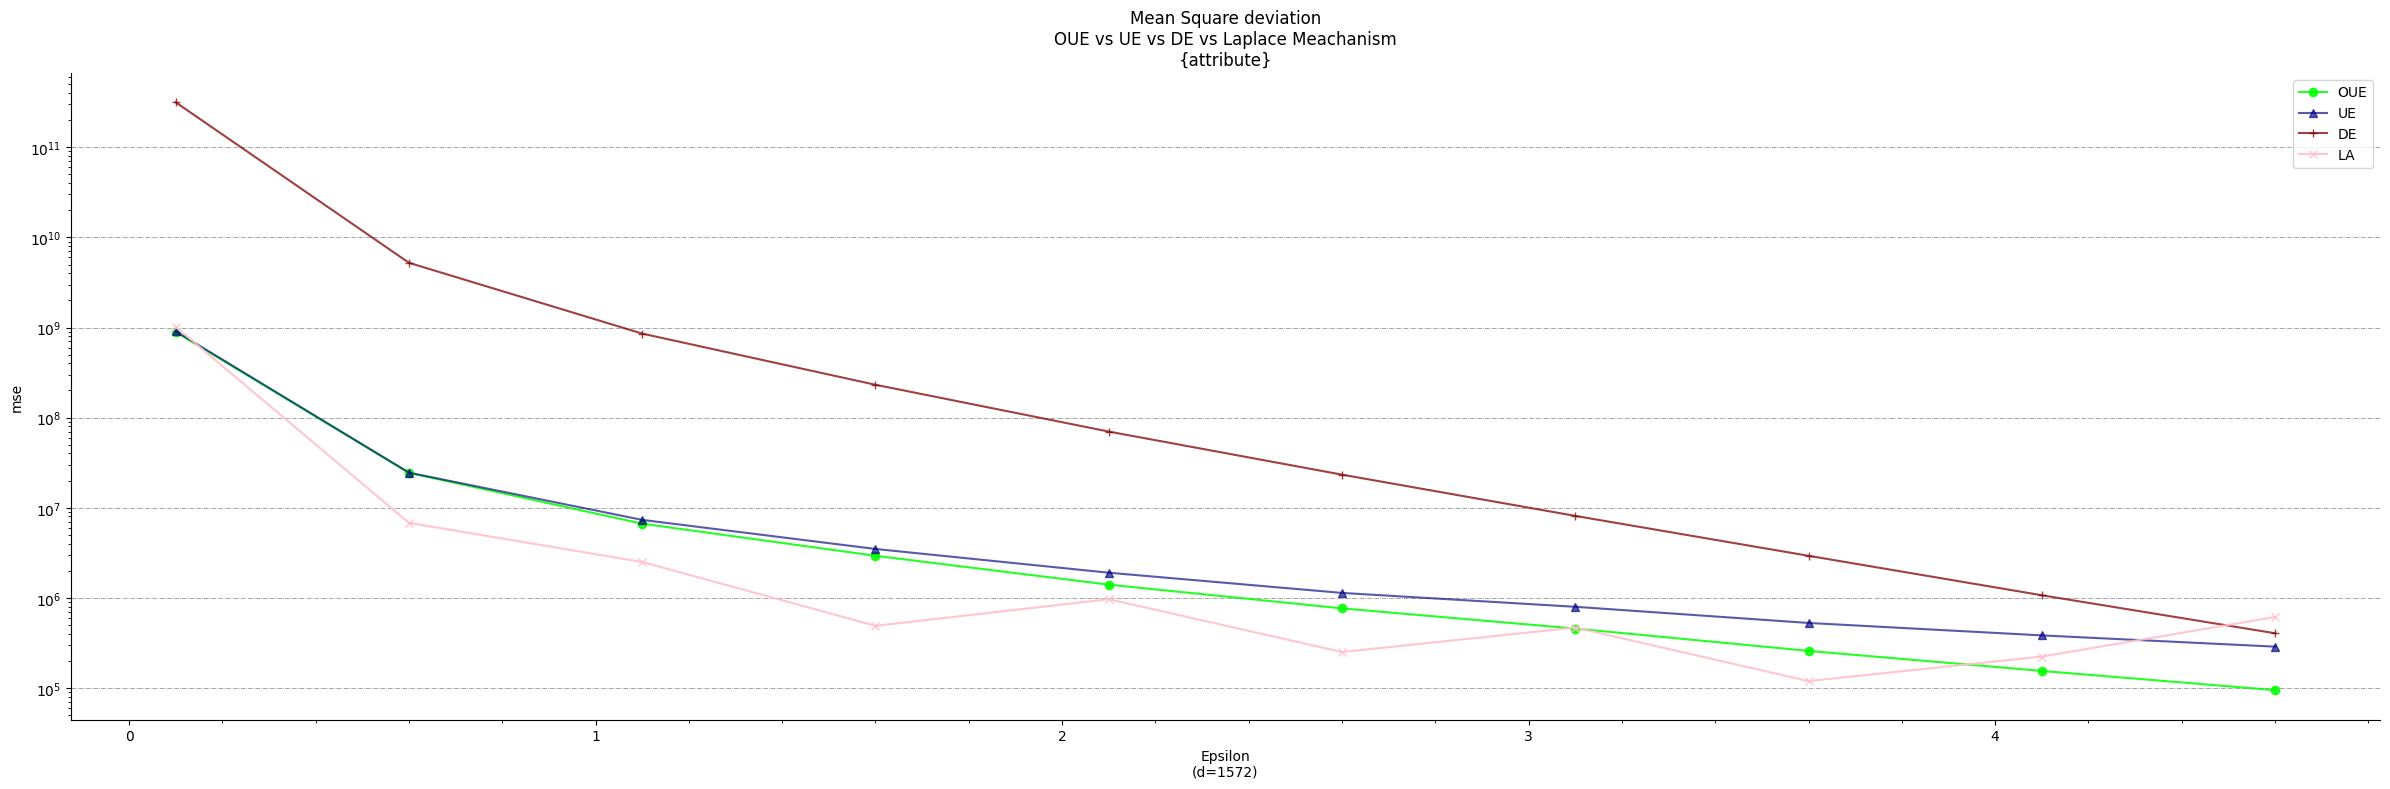

In [27]:
attribute = 'loan_amnt'
epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg, mseLA_avg = meid(5, attribute)
d = len(df[attribute].dropna().unique())
plt.figure(figsize=(24, 8))

plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
plt.plot(epsilon_avg, mseUE_avg, marker='^', color='navy', alpha=0.65, label='UE')
plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
plt.plot(epsilon_avg, mseLA_avg, marker='x', color='pink', alpha=0.9, label='LA')

plt.title('Mean Square deviation\nOUE vs UE vs DE vs Laplace Meachanism\n{attribute}')
plt.xlabel(f'Epsilon\n(d={d})')
plt.ylabel('mse')
plt.yscale('log')
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.minorticks_on()

plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')

plt.tight_layout()
plt.show()

In [ ]:
attribute = 'annual_inc'
epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg, mseLA_avg = meid(5, attribute)
d = len(df[attribute].dropna().unique())
plt.figure(figsize=(24, 8))

plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
plt.plot(epsilon_avg, mseUE_avg, marker='^', color='navy', alpha=0.65, label='UE')
plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
plt.plot(epsilon_avg, mseLA_avg, marker='x', color='red', alpha=0.9, label='LA')

plt.title('Mean Square deviation\nOUE vs UE vs DE vs Laplace Meachanism\n{attribute}')
plt.xlabel(f'Epsilon\n(d={d})')
plt.ylabel('mse')
plt.yscale('log')
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.minorticks_on()

plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')

plt.tight_layout()
plt.show()